## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset in this exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

The task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, the goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

## Loading the data

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


## Data Exploration

We start by exploring the data, and making sure it is clean for analysis.

In [2]:
# We visualize the shape of our dataset
print('Our training dataset has {} individuals. \
Among them, {} received the promotion and {} did not'.format(len(train_data),
                                                            len(train_data.loc[train_data.Promotion == 'Yes']),
                                                            len(train_data.loc[train_data.Promotion == 'No'])))

Our training dataset has 84534 individuals. Among them, 42364 received the promotion and 42170 did not


In [3]:
# We then compare the response rate for those who received the promotion and those who did not
train_data.groupby('Promotion')['purchase'].agg(lambda x: x.sum()/x.count())

Promotion
No     0.007565
Yes    0.017019
Name: purchase, dtype: float64

In [4]:
# We check for missing values
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [5]:
# We check for duplicates
train_data.duplicated().sum()

0

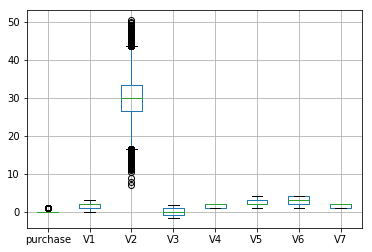

In [6]:
# Finally we visualize the distribution of values to make sure all our data seems valid
train_data.iloc[:,1:].boxplot();

Our dataset is relatively evenly split between people who received the promotion and those who did not, so the assignment between treatment and control appears to have been random. At first glance, the response rate (not taking incrementality into account) for people who received the promotion received a boost, but we will need to assess the significance of this result. 

We do not have missing values nor duplicates, and our features do not appear to have outliers (except for the feature V2). Given the lack of information about what the feature represents, we do not remove these extreme values, but we could test our approach with these values removed.

## Analysis

### Raw Results

In [7]:
def calculate_irr(df):
    '''
    df (dataframe): a dataframe containing the results for the treatment and control groups
    
    OUTPUT: a float representing the incremental response rate of this promotional campaign
    '''
    
    purch_treat = df.loc[df.Promotion == 'Yes','purchase'].sum()
    purch_cont = df.loc[df.Promotion == 'No','purchase'].sum()
    nb_treat = (df.Promotion == 'Yes').sum()
    nb_cont = (df.Promotion == 'No').sum()
    
    irr = (purch_treat/nb_treat) - (purch_cont/nb_cont)
    
    return irr

def calculate_nir(df):
    ''''
    df (dataframe): a dataframe containing the results for the treatment and control groups
    
    OUTPUT: a float representing the net incremental revenue of this promotional campaign
    '''
    purch_treat = df.loc[df.Promotion == 'Yes','purchase'].sum()
    purch_cont = df.loc[df.Promotion == 'No','purchase'].sum()
    nb_treat = (df.Promotion == 'Yes').sum()
    
    nir = (10*purch_treat - 0.15*nb_treat) - purch_cont
    
    return nir

In [8]:
print('The incremental response rate for this promotion on the training data is {:.1%}, which translates into\
a net incremental revenue of ${:.2f}'.format(calculate_irr(train_data), calculate_nir(train_data)))

The incremental response rate for this promotion on the training data is 0.9%, which translates intoa net incremental revenue of $536.40


### Permutation Test

In [9]:
def permtest(df, n_trials = 10000):
    """
    Compute a confidence interval for the irr and nir using a permutation method. 
    
    Input parameters:
        df: original dataframe on which to perform the test
        alternative: type of test to perform, {'less', 'greater'}
        n_trials: number of permutation trials to perform
    
    Output value:
        a confidence interval containing 95% of values
    """
    
    
    # initialize storage of permuted irr and nir
    sample_irr = []
    sample_nir = []
    
    # For each trial...
    for _ in range(n_trials):
        # randomly permute the grouping labels
        df.Promotion = np.random.permutation(df.Promotion)
        
        # compute the irr and nir on the permuted dataset
        irr = calculate_irr(df)
        nir = calculate_nir(df)
        
        # and add the value to the list of samples
        sample_irr.append(irr)
        sample_nir.append(nir)
    
    irr_ci = []
    irr_ci.append(np.percentile(np.array(sample_irr),0.025))
    irr_ci.append(np.percentile(np.array(sample_irr),0.975))
    nir_ci = []
    nir_ci.append(np.percentile(np.array(sample_nir),0.025))
    nir_ci.append(np.percentile(np.array(sample_nir),0.975))
    
    return irr_ci, nir_ci

In [10]:
irr_ci, nir_ci = permtest(train_data, n_trials = 1000)
irr_ci, nir_ci

([-0.0024224399938946196, -0.0018791527735942163],
 [-2224.6109999999994, -2098.3144999999995])

### Logistic Regression

In [11]:
# We first create an intercept, map our Promotion variable to a numeric value and then fit our model
train_data = add_constant(train_data)
train_data.Promotion = train_data.Promotion.map({'Yes': 1, 'No': 0})
model = sm.Logit(train_data.purchase, train_data[['Promotion', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'const']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.065691
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               purchase   No. Observations:                84534
Model:                          Logit   Df Residuals:                    84525
Method:                           MLE   Df Model:                            8
Date:                Fri, 30 Nov 2018   Pseudo R-squ.:                0.009692
Time:                        13:09:58   Log-Likelihood:                -5553.1
converged:                       True   LL-Null:                       -5607.4
                                        LLR p-value:                 7.070e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Promotion      0.0473      0.062      0.758      0.449      -0.075       0.170
V1            -0.0516      0.036     -1.436      0.151      -0.122       0.019
V2            -0.0032      0.006     -0.515      0.606      -0.015       0.009
V3            -0.0588      0.031     -1.882      0.060      -0.120       0.002
V4             0.7350      0.080      9.175      0.000       0.578       0.892
V5             0.0833      0.037      2.238      0.025       0.010       0.156
V6            -0.0129      0.028     -0.461      0.645      -0.068       0.042
V7            -0.0201      0.068     -0.296      0.767      -0.153       0.113
const         -5.6550      0.295    -19.178      0.000      -6.233      -5.077
==============================================================================
"""

### Interpretation

Our double-pronged analysis yields similar results:
- fitting a logistic regression allows us to assess whether, controlling for other variables, receiving the promotion in itself has an impact on the probability of buying an object. Here, at the 10% significance level, we can conclude that there is a significant impact. We do not include interaction terms, for we are more interested in the overall impact of the promotion.
- conducting a permutation test confirms this analysis on the two metrics of interest. With this test, we can use permutation methods to build a confidence interval for the NIR and IRR, and see that our observed values are outside of these intervals. Thus, we conclude there is a significant impact.

Thus, the promotion seems to be beneficial when it comes to prompting a purchase. We now try to determine whether we can optimize our strategy by establishing rules around whom should receive the promotion.

## Promotion Strategy Optimization

Both metrics of interest boil down to increasing the response rate for people who do receive the promotions. In other words, we only want to send the promotion to people who are the most likely to purchase when they receive a promotion and avoid those for whom the promotion has no impact, since it costs money to send the promotion. The idea is to find values of the features associated with purchasing.

This brings to mind a classification problem. We will build a decision tree on our training set, and use it to make predictions for the test set. These predictions, based on combinations of features, will help us decide who to send the promotion to, based on the probability of purchasing output by our model.

### Modeling

In [12]:
# We split our dataset into train and test sets and then fit a DecisionTreeClassifier
# We first remove the constant that was created for our previous model
train_data.drop(labels='const', axis=1, inplace=True)
X = train_data.iloc[:,3:]
y = train_data.purchase

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = DecisionTreeClassifier(random_state=42, max_depth=4)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print('The accuracy is {} but the F-1 score is {}'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

The accuracy is 0.9875791092446915 but the F-1 score is 0.0


Simply fitting a decision tree is not enough: only about 1% of the customers in the training set purchased, regardless of them receiving the promotion or not. We have an imbalance in our classes, which biases our algorithm: a very high accuracy can be achieved by always predicting a customer will not purchase. We downsample our dominant class and re-train our model to deal with this.

In [13]:
# We downsample our dominant class in our training set
i_class0 = np.where(y_train == 0)[0]
i_class1 = np.where(y_train == 1)[0]

# Number of observations in each class
n_class0 = len(i_class0)
n_class1 = len(i_class1)

# For every observation of class 0, randomly sample from class 1 without replacement
i_class0_downsampled = np.random.choice(i_class0, size=n_class1*2, replace=False)

# Create new indices based on the downsampled class 0
indices = np.concatenate((i_class0_downsampled, i_class1))
np.random.shuffle(indices) # we shuffle to avoid order in our dataset

# We subset our X_train and y_train datasets, we now have a ratio of 2:1 for class 0 vs 1
X_train = X_train.iloc[indices]
y_train = y_train.iloc[indices]

In [14]:
# We can fit a new model
tree = DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_leaf=7, min_samples_split=20)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print('The accuracy is {} but the F-1 score is {}'.format(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

The accuracy is 0.9756313952800615 but the F-1 score is 0.0


In [15]:
# We now examine feature importance
tree.feature_importances_

array([0.05217911, 0.23598669, 0.125073  , 0.34735228, 0.23940891,
       0.        , 0.        ])

The F1-score of our decision tree is still extremely low, but we go ahead using it regardless to predict probability of purchasing. For our specific purposes, we will send a promotion to someone who, according to our model, has a probability of purchasing greater than 40%, as it is much higher than our baseline.

### Promotion Strategy

In [16]:
def compare_features(row):
    '''
    A helper function to get the predicted probability of purchasing for a given individual and make a decision based on a
    chosen boundary.
    
    INPUTS:
    row: an array containing the values of interest in a row
    
    OUTPUT:
    a string specifying whether a given individual (characterized by a row) should be sent the promotion or not
    '''
    if tree.predict_proba(row.values.reshape(1,-1))[0][1] > 0.4:
        return 'Yes'
    else:
        return 'No'

In [17]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''    
    promotion = df.apply(compare_features, axis = 1)
    
    return promotion
    

Now that we have our promotion strategy, we test it out on our test set.

In [18]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0201.

Your nir with this strategy is 311.65.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.02011544509583637, 311.6500000000001)

As we can see, our strategy outperforms the optimal strategy devised by Udacity. Our incremental response rate is 2.01% while our net incremental revenue is $311.65. This means that my strategy was more targeted (and thus more efficient, as more people responded), and reached a large enough audience to generate a lot of incremental revenue.

Although this approach was devised with a decision tree, we could test different classification models (Random Forest, Logistic Regression, Gradient Boosting...) and see which yields the best results. We could also test various threshold (i.e. probability of purchasing) or try to remove outliers in the V2 feature. In order to test all these alternatives, the approach I would take would be to build a pipeline with GridSearch, and define a custom scoring method based on the NIR and IRR on the test set that the process would optimize towards, choosing the best combination of parameters (see the disaster_response_pipeline repository for an example). As a first iteration, the results are satisfactory here.